In [ ]:
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker
!pip install scikit-learn


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# CARGAR DATOS

**DATOS DE ENTRENAMIENTO**

la columna de trastornos indica si el TWEET es de una persona con depresión o es de control.


**control**:     0

**depresión**:   1



In [ ]:
num_docs = 50000

In [ ]:
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /entrenamiento y prueba (control vs depresión)/train.csv'
#data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data_train = data.iloc[:num_docs, :]
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     5000 non-null   object 
 1   TWEET_ID    4999 non-null   float64
 2   TWEET_TEXT  4996 non-null   object 
 3   trastorno   5000 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 156.4+ KB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,87,2.147484e+09,RT @Julii_AKD: por qué a la mayoría de las pib...,1
1,6,2.147484e+09,Empezar un 2017 sintiéndote solo.,1
2,279,2.147484e+09,Ah mirá que lindo como me escrachan en Instagr...,0
3,518,2.147484e+09,https://t.co/hC3rULMb1P,0
4,301,2.147484e+09,"Tu sigue con él, cumple tu deber, muy pronto v...",0
5,177,2.147484e+09,@Sebbasrp deje dormir al prójimo.,0
6,45,2.147484e+09,"RT @Crookedgirlx: no quiero vivir más, estoy c...",1
7,29,2.147484e+09,RT @Esunbreakable: Me da un poquito de vergüen...,1
8,388,2.147484e+09,Venezuela-related Designation https://t.co/IOZ...,0
9,31,2.147484e+09,Tengo muchas ganas de escribirte para decirte ...,1


**DATOS DE PRUEBA**

In [ ]:
num_docs_t = 50000

In [ ]:
ruta_archivo_prueba = '/content/drive/MyDrive/Experimentación Python Tesis /entrenamiento y prueba (control vs depresión)/test.csv'
data_test = pd.read_csv(ruta_archivo_prueba, lineterminator='\n')
data_test = data.iloc[:num_docs_t, :]
data_test.info()
data_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     50000 non-null  object 
 1   TWEET_ID    49991 non-null  float64
 2   TWEET_TEXT  49972 non-null  object 
 3   trastorno   50000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,87,2.147484e+09,RT @Julii_AKD: por qué a la mayoría de las pib...,1
1,6,2.147484e+09,Empezar un 2017 sintiéndote solo.,1
2,279,2.147484e+09,Ah mirá que lindo como me escrachan en Instagr...,0
3,518,2.147484e+09,https://t.co/hC3rULMb1P,0
4,301,2.147484e+09,"Tu sigue con él, cumple tu deber, muy pronto v...",0


In [ ]:
# Verificar si hay filas nulas o vacías en la columna 'trastorno'
null = data_test['trastorno'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'trastorno':", null)

Número de filas nulas o vacías en la columna 'trastorno': 0


# Preparación de los datos

*Eliminar etiquedas HTML*

In [ ]:
import re

def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

*Limpiar texto*

In [ ]:
import re
import string

def clean(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        # Eliminar hashtags
        text = re.sub(r'#\w+', '', text)

        # Eliminar URLs o enlaces
        text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

        # Eliminar nombres de usuarios de Twitter
        text = re.sub(r'@\w+', '', text)

        # Eliminar Nombres propios
        text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

        # Eliminar todos los caracteres especiales
        text = re.sub(r'[^\w\s]+', '', text)

        # Eliminar prefijos y números
        text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

        # Eliminar palabras específicas
        specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                          'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                          'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                          'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                          'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                          'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                          'it','we','they','the','and','that','these','those','tweet','followed','follower']
        text = ' '.join([word for word in text.split() if word not in specific_words])

        # Eliminar emojis
        emojis = re.findall(r'[^\w\s,]', text)
        cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                     '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                     ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
        for emoji in cleaned_emojis:
            text = text.replace(emoji, '')

        # Convertir el texto a minúsculas
        text = text.lower()

        # Eliminar signos de puntuación
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

        # Devuelve el texto limpio
        return text
    else:
        return text  # Devolver el valor original si no es de tipo string


#Elaboración de la lista de palabras relevantes a partir de una bolsa de palabras del mismo conjunto de datos

In [ ]:
import nltk
nltk.download('stopwords')  #Solamente se ha de descargar la primera vez.
stopwords_es = nltk.corpus.stopwords.words('spanish')   # Extrae las stopwords en español

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

# Inicializar stemmer de NLTK
stemmer = PorterStemmer()

In [ ]:
# # Función para lematizar y extraer términos
# from nltk.stem import SnowballStemmer

# spanish_stemmer = SnowballStemmer('spanish')

# def extractTerms(text):
#     # Tokenización y lematización con spaCy
#     doc = nlp(text)
#     lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

#     # Stemming con SnowballStemmer de NLTK
#     stemmed_terms = [spanish_stemmer.stem(term) for term in lemmatized_terms]

#     return stemmed_terms
# # Ejemplo de uso
# texto_ejemplo = "Los perrito  están corriendo en el parque y jugando felices."
# terminos_extraidos = extractTerms(texto_ejemplo)
# print(terminos_extraidos)

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))
def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gato', 'saltar', 'valla']


# Preprocesamieto del conjunto de datos de entrenamiento

In [ ]:
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(removeHTML)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(clean)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(extractTerms)
data_train.head(10)

,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,87,2.147484e+09,"[mayoría, piba, gustar, tener, pierna, grande,...",1
1,6,2.147484e+09,"[sintiéndote, solo]",1
2,279,2.147484e+09,"[mier, lindo, escrachan, magnifico]",0
3,518,2.147484e+09,[],0
4,301,2.147484e+09,"[seguir, cumple, deber, pronto, vestido, novia...",0
5,177,2.147484e+09,"[dejar, dormir, prójimo]",0
6,45,2.147484e+09,"[querer, vivir, cansado]",1
7,29,2.147484e+09,"[poquito, vergüenza, alguien, querer, alzarme,...",1
8,388,2.147484e+09,[related],0
9,31,2.147484e+09,"[mucho, gana, escribirtar, decirte, extraño, d...",1


In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 3437


In [ ]:
# Eliminar filas con valores vacíos en la columna "TWEET_TEXT"
data_train = data_train[data_train['TWEET_TEXT'].notnull()]

In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 3437


In [ ]:
# from spellchecker import SpellChecker

# def corrector_ortografico(tokens):
#     spell = SpellChecker(language='es')
#     tokens_corregidos = [spell.correction(token) if spell.correction(token) is not None else token for token in tokens]
#     return tokens_corregidos

# def corregir_palabras_largas(tokens):
#     tokens_corregidos = []
#     for token in tokens:
#         # Corregir repeticiones de letras
#         token_corregido = re.sub(r'(.)\1+', r'\1\1', token)

#         # Corregir alargamiento de palabras
#         token_corregido = re.sub(r'(\w)\1{2,}', r'\1\1', token_corregido)

#         # Eliminar vocales repetidas más de 2 veces seguidas
#         token_corregido = re.sub(r'([aeiouáéíóú]{2,})\1+', r'\1', token_corregido, flags=re.IGNORECASE)

#         tokens_corregidos.append(token_corregido)
#     return tokens_corregidos

In [ ]:
# data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(corregir_palabras_largas)
# data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(corrector_ortografico)

data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) # Combinar los elementos de la lista en una sola cadena separados por espacios
data_train.info()
data_train.head(10)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     50000 non-null  object 
 1   TWEET_ID    49991 non-null  float64
 2   TWEET_TEXT  50000 non-null  object 
 3   trastorno   50000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.9+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,87,2.147484e+09,mayoría piba gustar tener pierna grande linda ...,1
1,6,2.147484e+09,sintiéndote solo,1
2,279,2.147484e+09,mier lindo escrachan magnifico,0
3,518,2.147484e+09,,0
4,301,2.147484e+09,seguir cumple deber pronto vestido novia estar...,0
5,177,2.147484e+09,dejar dormir prójimo,0
6,45,2.147484e+09,querer vivir cansado,1
7,29,2.147484e+09,poquito vergüenza alguien querer alzarme pesar...,1
8,388,2.147484e+09,related,0
9,31,2.147484e+09,mucho gana escribirtar decirte extraño deber h...,1


# Representación de los datos mediante una matriz TF-IDF

se guardan los valores de la matriz BoW y los array X y para futuros entrenamientos

Se procederá a construir un conjunto de entrenamiento a partir de la representación de bolsa de palabras o inglés (Bag of Words.)

In [ ]:
import joblib
from sklearn.feature_extraction.text import CountVectorizer

# Crear un transformador CountVectorizer con el tokenizer extractTerms y rango de n-gramas (1, 1)
count_vect = CountVectorizer(tokenizer=extractTerms, ngram_range=(1, 1))

# Aplicar el CountVectorizer a la columna 'TWEET_TEXT' en data_train y obtener la matriz BoW
bow_train = count_vect.fit_transform(data_train['TWEET_TEXT'].values)

# Imprimir el tamaño del vocabulario construido por CountVectorizer
print("El tamaño del vocabulario es:", len(count_vect.vocabulary_))

# Crear arrays X y y para los datos y etiquetas respectivamente
X = bow_train  # Matriz BoW
y = data_train['trastorno'].values  # Etiquetas de trastorno de la columna 'trastorno'



El tamaño del vocabulario es: 29847


In [ ]:
# Obtener el vocabulario construido por CountVectorizer
vocabulario = count_vect.get_feature_names_out()

# Imprimir el vocabulario
print("Vocabulario:")
print(vocabulario)

Vocabulario:
[' ' '  ' 'aaa' ... '𝐪𝐮𝐞' '𝐮𝐬𝐭𝐞𝐝' '𝗜𝗻𝘃𝗶𝘁𝗮𝗱𝗼']


# Entrenamiento y validación del modelo

In [ ]:
from sklearn.model_selection import train_test_split

#
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.25)

# Aprendizaje del modelo: Maquina de Soporte Vectorial

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

svm_model_p = SVC(kernel='poly', degree=4, C=10, max_iter=50000,  probability=True)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcula la precisión del modelo en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)


# Calcula precisión, exhaustividad y puntuación F1 en el conjunto de validación
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcula y muestra métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

print(f"Exactitud en el conjunto de validación: {round(accuracy,2)*100}%")
print(f"Precisión en el conjunto de validación:{round(precision,2)*100}%")
print(f"Recall en el conjunto de validación: {round(recall,2)*100}%")
print(f"F1-score en el conjunto de validación:{round(f1,2)*100}%")

print("\nMétricas en el conjunto de entrenamiento:")
print("Exactitud (entrenamiento): {:.2f}%".format(accuracy_train*100))
print("Precision (entrenamiento): {:.2f}%".format(precision_train*100))
print("Recall (entrenamiento): {:.2f}%".format(recall_train*100))
print("F1-score (entrenamiento): {:.2f}%".format(f1_train*100))

Exactitud en el conjunto de validación: 66.0%
Precisión en el conjunto de validación:62.0%
Recall en el conjunto de validación: 85.0%
F1-score en el conjunto de validación:71.0%

Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 93.69%
Precision (entrenamiento): 89.38%
Recall (entrenamiento): 99.13%
F1-score (entrenamiento): 94.00%


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

import numpy as np

# Crear un modelo de SVM
svm_model_p = SVC(kernel='poly', degree=4, C=10, max_iter=50000, probability=False)



# Listas para almacenar métricas de entrenamiento y validación
train_accuracy_scores = []
train_precision_scores = []
train_recall_scores = []
train_f1_scores = []

val_accuracy_scores = []
val_precision_scores = []
val_recall_scores = []
val_f1_scores = []

from sklearn.model_selection import StratifiedKFold
# Definir la estrategia de validación cruzada (k=10)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Realizar la validación cruzada
for train, val in cv.split(X, y):
    X_train, X_val = X_train[train], X_train[val]
    y_train, y_val = y_train[train], y_train[val]

    # Entrenar el modelo en los datos de entrenamiento del fold
    svm_model_p.fit(X_train_fold, y_train_fold)

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = svm_model_p.predict(X_train_fold)

    # Calcular métricas de entrenamiento y agregarlas a las listas
    train_accuracy_scores.append(accuracy_score(y_train_fold, y_train_pred))
    train_precision_scores.append(precision_score(y_train_fold, y_train_pred))
    train_recall_scores.append(recall_score(y_train_fold, y_train_pred))
    train_f1_scores.append(f1_score(y_train_fold, y_train_pred))

    # Evaluar el modelo en el conjunto de validación
    y_val_pred = svm_model_p.predict(X_val_fold)

    # Calcular métricas de validación y agregarlas a las listas
    val_accuracy_scores.append(accuracy_score(y_val_fold, y_val_pred))
    val_precision_scores.append(precision_score(y_val_fold, y_val_pred))
    val_recall_scores.append(recall_score(y_val_fold, y_val_pred))
    val_f1_scores.append(f1_score(y_val_fold, y_val_pred))

# Calcular las métricas promediadas en entrenamiento y validación
train_accuracy_mean = np.mean(train_accuracy_scores)
train_precision_mean = np.mean(train_precision_scores)
train_recall_mean = np.mean(train_recall_scores)
train_f1_mean = np.mean(train_f1_scores)

val_accuracy_mean = np.mean(val_accuracy_scores)
val_precision_mean = np.mean(val_precision_scores)
val_recall_mean = np.mean(val_recall_scores)
val_f1_mean = np.mean(val_f1_scores)

# Imprimir las métricas en entrenamiento y validación
print("Entrenamiento - Accuracy: {:.2f}%".format(100 * train_accuracy_mean))
print("Entrenamiento - Precision: {:.2f}%".format(100 * train_precision_mean))
print("Entrenamiento - Recall: {:.2f}%".format(100 * train_recall_mean))
print("Entrenamiento - F1 Score: {:.2f}%".format(100 * train_f1_mean))

print("\nValidación - Accuracy: {:.2f}%".format(100 * val_accuracy_mean))
print("Validación - Precision: {:.2f}%".format(100 * val_precision_mean))
print("Validación - Recall: {:.2f}%".format(100 * val_recall_mean))
print("Validación - F1 Score: {:.2f}%".format(100 * val_f1_mean))


Entrenamiento - Accuracy: 93.72%
Entrenamiento - Precision: 89.36%
Entrenamiento - Recall: 99.23%
Entrenamiento - F1 Score: 94.04%

Validación - Accuracy: 65.13%
Validación - Precision: 60.78%
Validación - Recall: 84.91%
Validación - F1 Score: 70.84%


In [ ]:
import joblib
import os
# Directorio para guardar modelos entrenados
model_dir = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/Modelos ya entrenados'
model_filename = 'TWEETS_depresivos (SVM_p (Bow)).pkl'
model_path_p = os.path.join(model_dir, model_filename)

# Guardar el modelo entrenado
joblib.dump(svm_model_p, model_path_p)

['/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/Modelos ya entrenados/TWEETS_depresivos (SVM_p (Bow)).pkl']

# matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = svm_model_p.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
# y las columnas a las predicciones.
#
cm = confusion_matrix(y_val, y_pred)

# Obtiene la proporción real de comentarios positivos,
# y la proporción etiquetados.
#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[2926 3298]
 [ 957 5319]] 

Proporción de comentarios positivos: 0.50
Proporción de comentarios positivos etiquetados: 0.69


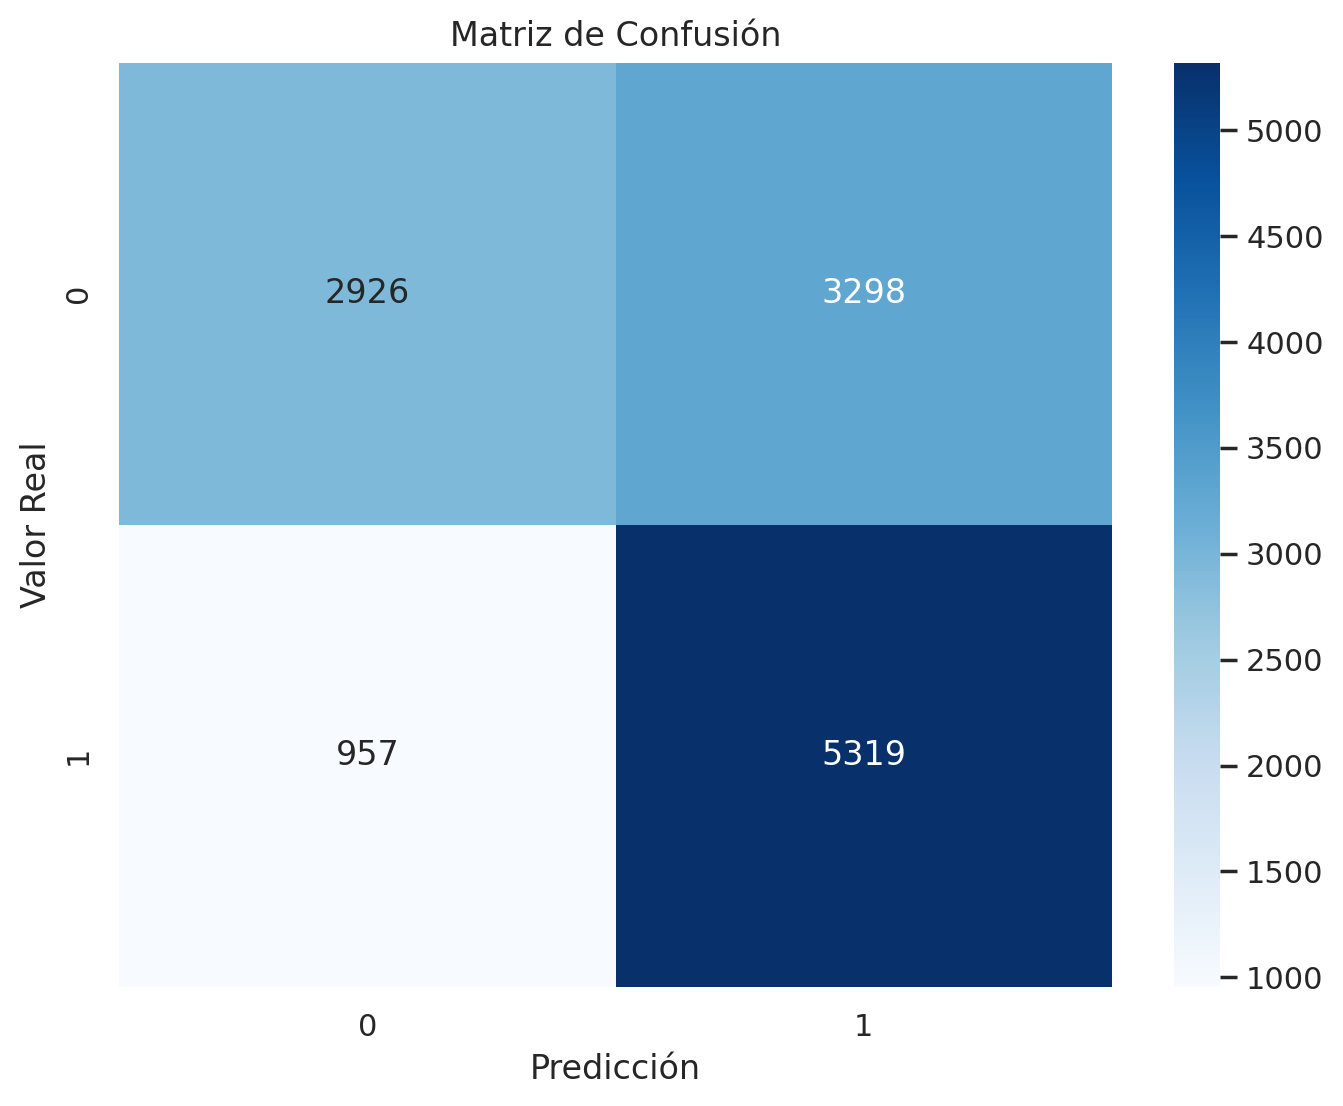

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()